In [1]:
import numpy as np
import pandas as pd 
import cv2
import skimage
import rasterio
from osgeo.gdalconst import *
from numpy import *
import matplotlib as mpl
from osgeo import gdal
from gdalconst import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gds
from mpl_toolkits.axes_grid1 import make_axes_locatable

import geopandas as gpd 

import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
from sklearn.preprocessing import LabelEncoder


from multiprocessing import Pool
from shapely.geometry import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Misc
import pickle
import sys
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import datetime
import itertools
from tqdm import tqdm_notebook as tqdm
import enum

from skimage.feature import local_binary_pattern
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize 

c:\users\envisagepc\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Satellite Image Dataset Preparation

Preparation of Sentinel Images by converting them to numpy arrays and creating band indices for the classification

In [3]:
"""
Task that reads Sentinel L2A data from a folder 
"""
def _READ_(folder):
    
    array = []
    
    for root, dirs, files in os.walk (folder):
        for name in files:
            if name.endswith((".tif")) and not name.startswith(('.')):
                #print ('img file:', name)
                date = name.split('_', 4)[2]
                image = root+"/"+name
                band = _band_indices_(image)
                array.append(band)
                del band
            
    dataset = np.dstack([array])
                
    return dataset

In [4]:
"""
Task that calculates user defined Normalized Difference Indices as well as other Band Indices
"""
def _band_indices_(file):
    
    file = gdal.Open(file, gdal.GA_ReadOnly)
    
    gtr = file.GetGeoTransform()
    dvr = file.GetDriver()
    col = file.RasterXSize
    row = file.RasterYSize
    bnd = file.RasterCount
    prj = file.GetProjection()
    
    array = []
    
    for b in range(bnd+1)[1::]:
        band = file.GetRasterBand(b)
        arry = band.ReadAsArray().astype(np.float64)
        mask = arry == 0.0
        arry[mask] = np.nan
        array.append(arry)
        del band, arry
        
    img = ma.masked_invalid(array)
    
    band_01 = img[0]
    band_02 = img[1]
    
    var_01 = band_01/band_02
    var_02 = (band_01 + band_02)/2
    var_03 = band_01*band_02
    
    #blue  = img[0]
    #green = img[1]
    #red   = img[2]
    #nir   = img[6]
    #swir  = img[8]
    #blue = file.GetRasterBand(1).ReadAsArray().astype(np.float64)
    #green = file.GetRasterBand(2).ReadAsArray().astype(np.float64)
    #red = file.GetRasterBand(3).ReadAsArray().astype(np.float64)
    #nir = file.GetRasterBand(7).ReadAsArray().astype(np.float64)
    #swir = file.GetRasterBand(9).ReadAsArray().astype(np.float64)
    
    #NDVI ((NIR - RED)/(NIR + RED))
    #ndvi = (nir-red)/(nir+red)
    
    #NDWI ((GREEN - NIR)/(GREEN + NIR))
    #ndwi = (nir-swir)/(nir+swir)
    
    #NDBI
    #ndbi = (swir-nir)/(swir+nir)
    
    #GNDVI
    #gndvi = (nir-green)/(nir+green)
    
    #Norm
    #norm = np.sqrt(red**2 + green**2 + blue**2 + nir**2 + swir**2)
    
    #rgb = []
    #rgb.append(red)
    #rgb.append(green)
    #rgb.append(blue)
    #rgb = np.moveaxis(np.array(np.float32(rgb)), 0, 2)    
    #gray = cv2.cvtColor(np.float32(rgb), cv2.COLOR_BGR2GRAY)
    gray = skimage.color.rgb2gray(band_01)
    radius = 2
    points = radius
    lbp = local_binary_pattern(gray, points, radius, method='uniform')
    
    
    #array.append(ndvi)
    #array.append(ndwi)
    #array.append(ndbi)
    #array.append(norm)
    
    array.append(var_01)
    array.append(var_02)
    array.append(var_03)
    array.append(lbp)
    
    band = np.dstack(b for b in array)

    return band

In [6]:
%%time
#dataset = _READ_(r'C:\Users\EnvisagePC\Desktop\eo-learn\Sentinel Mosaic\2018')
dataset = _READ_(r'C:\Users\EnvisagePC\Desktop\eo-learn\SAR')
mask_train = dataset == 0.0
dataset[mask_train] = np.nan
print ('Dataset structure : {t} x {n} x {m} x {b}'.format(t=dataset.shape[0], n=dataset.shape[1], m=dataset.shape[2], b=dataset.shape[3]))
dataset

c:\users\envisagepc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Dataset structure : 1 x 12067 x 10852 x 6
Wall time: 1min 21s


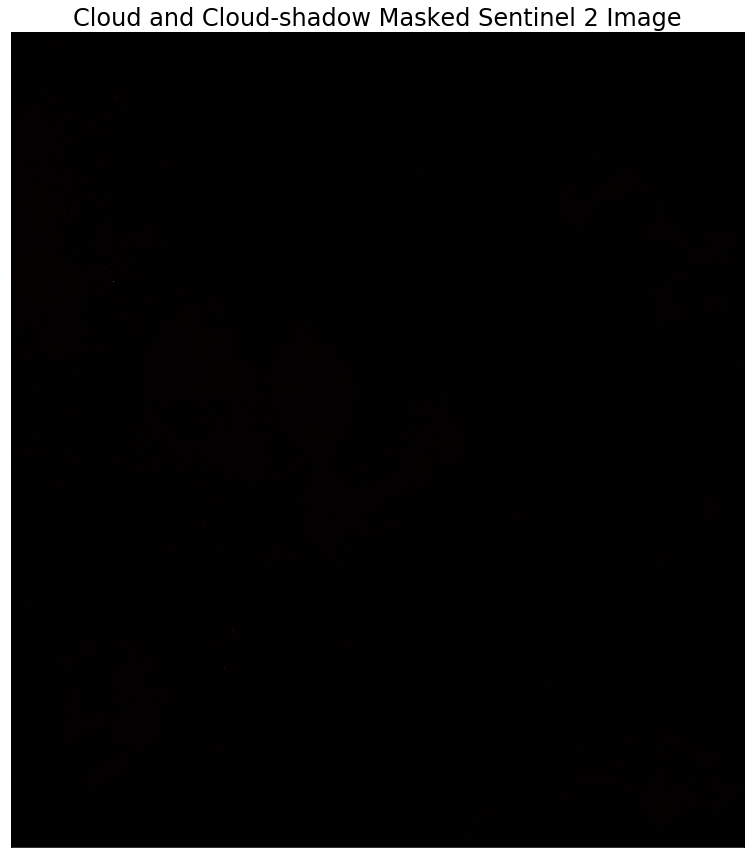

In [8]:
img = np.moveaxis(dataset[0],2,0)
img = ma.masked_invalid(img)

def normalize(array):
    'Normalizes numpy arrays into scale of 0 - 1.0'
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

#vi = img[12]
red   = normalize(img[2])
green = normalize(img[1])
blue  = normalize(img[0])

rgb = np.dstack((red, green, blue))
plt.figure(figsize=(25,15))
plt.imshow(rgb)
plt.title('Cloud and Cloud-shadow Masked Sentinel 2 Image', fontsize=24)
plt.xticks([])
plt.yticks([])
plt.show()

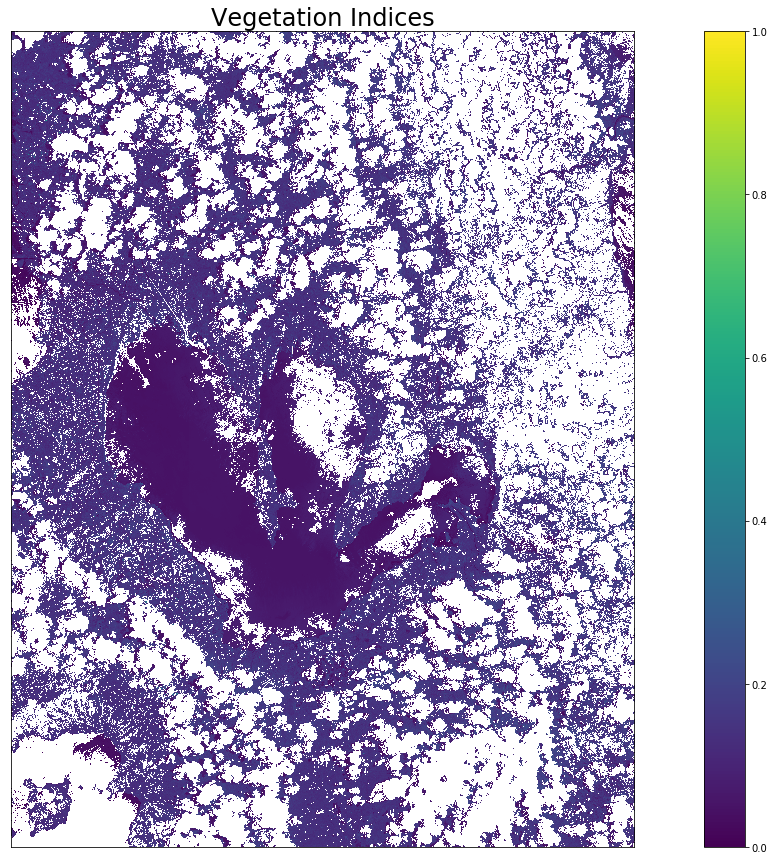

In [8]:
raster = normalize(img[12])
plt.figure(figsize=(25,15))
plt.imshow(raster)
plt.title('Vegetation Indices', fontsize=24)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
max_raster = normalize(img[7]).max()
min_raster = normalize(img[7]).min()
ave_raster = normalize(img[7]).mean()
print('Mean: {ave}, Max: {mx}, Min: {mn}'.format(ave=ave_raster, mx=max_raster, mn=min_raster))

Mean: 0.12227446251458729, Max: 1.0, Min: 0.0


# Training Dataset Prepration

Rasterize vector layer for training dataset

In [9]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray().astype(np.uint8)
        ds = None
    return labeled_pixels

In [10]:
img = r'C:\Users\EnvisagePC\Desktop\eo-learn\SAR\LandCover_LagunaLakeWatershed_SAR.tif'
#img = r'C:\Users\EnvisagePC\Desktop\eo-learn\Sentinel Mosaic\2016\S2A_MSIL2A_20160408T021612_N0201_R003_T511.tif'
file = r'C:\Users\EnvisagePC\Desktop\eo-learn\Land_Cover_Training'
files = [f for f in os.listdir(file) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(file, f) for f in files if f.endswith('.shp')]

ras = gdal.Open(img, gdal.GA_ReadOnly)
gtr = ras.GetGeoTransform()
dvr = ras.GetDriver()
col = ras.RasterXSize
row = ras.RasterYSize
bnd = ras.RasterCount
prj = ras.GetProjection()

labels = []
legend = []
for item in shapefiles:
    labels.append(item)
for counter, value in enumerate(labels):
    lhs, rhs = value.split("C:\\Users\\EnvisagePC\\Desktop\\eo-learn\\Land_Cover_Training\\",1)
    lhs1, rhs1 = rhs.split(".shp",1)
    legend.append(lhs1)
    print ("class "+str(counter+1)+": "+lhs1)

class 1: Agricultural_land
class 2: Artificial_surface
class 3: Bare_land
class 4: Forest
class 5: Grass_land
class 6: Shrub_land
class 7: Water


In [11]:
%%time
ground_truth = vectors_to_raster(shapefiles, row, col, gtr, prj)
labels_unique = np.unique(ground_truth[ground_truth > 0]) 
print (labels_unique)

[1. 2. 3. 4. 5. 6. 7.]
Wall time: 22.1 s


In [12]:
class LULC(enum.Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    ARTIFICIAL_SURFACE = (2,  'Artificial Surface', 'crimson')
    BARELAND           = (3,  'Bareland',           'xkcd:beige')
    FOREST             = (4,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (5,  'Grassland',          'green')
    SHRUBLAND          = (6,  'Shrubland',          'xkcd:orange')
    WATER              = (7,  'Water',              'xkcd:azure')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3  

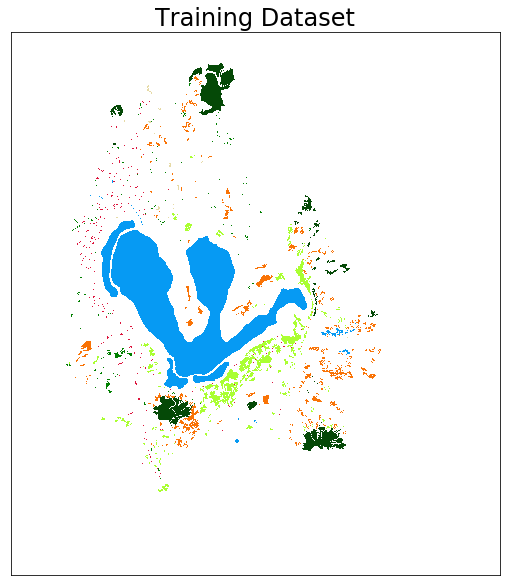

In [13]:
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 8, 1), lulc_cmap.N)
plt.figure(figsize=(20,10))
plt.imshow(ground_truth, cmap=lulc_cmap)
plt.xticks([])
plt.yticks([])
plt.title('Training Dataset', fontsize=24)
plt.show()

# LightGBM Classification

In [14]:
ground_truth.shape

(12067, 10852)

Dataset Preprocessing

In [15]:
t, w, h, b = dataset.shape
feature = ma.masked_invalid(dataset)
mask = ma.getmask(feature)
mask = np.moveaxis(mask, 0, 2).reshape(w*h,t*b)
mask.shape

(130951084, 6)

In [16]:
features_train = []
for i in range(dataset.shape[0]):
    features_train.append(feature[i][ground_truth>0,:])
    
features_train = np.stack([b for b in features_train])
t, n, b = features_train.shape
features_train = np.moveaxis(features_train, 0, 1).reshape(n, t*b)
features_train = ma.masked_invalid(features_train)
mask_train = ma.getmask(features_train)
features_train

masked_array(
  data=[[0.01787480339407921, 0.05040475353598595, 0.3546253505895566,
         0.03413977846503258, 0.0009009750595827676, 1.0],
        [0.025014566257596016, 0.075996994972229, 0.32915204432408013,
         0.05050578061491251, 0.0019010318661110137, 1.0],
        [0.042694028466939926, 0.14950716495513916, 0.28556509970442295,
         0.09610059671103954, 0.006383063156606195, 1.0],
        [0.007803994230926037, 0.02985887974500656, 0.26136259288934427,
         0.0188314369879663, 0.0002330185252719455, 2.0],
        [0.009590131230652332, 0.04111940413713455, 0.23322641540886468,
         0.025354767683893442, 0.0003943404818013488, 1.0],
        [0.021864652633666992, 0.06716251373291016, 0.32554845580404684,
         0.044513583183288574, 0.0014684850327739696, 1.0],
        [0.0538911372423172, 0.11815393716096878, 0.4561095341994216,
         0.08602253720164299, 0.006367450043261891, 1.0],
        [0.0823776125907898, 0.2721470296382904, 0.30269524786023777,


In [17]:
labels_train = ground_truth[ground_truth>0]
labels_train.shape

(9453144,)

Splitting of Training Dataset into Train and Test Dataset

In [18]:
# Set up the model
X_train, X_test, y_train, y_test = train_test_split(features_train, labels_train,
                                                    train_size=0.75, test_size=0.25)
le = LabelEncoder()
yTrain = le.fit_transform(y_train)
yTest  = le.fit_transform(y_test)

Parameter Tuning of LightGBM

In [19]:
%%time
fit_params = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'multi_logloss', 
             "eval_set" : [(X_test, yTest)],
             'eval_names': ['valid'],
             'verbose': 0}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 5000], 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], 
              'num_leaves' : [i for i in range(30,150,2)],
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'output_model': 'LightGBM_model.txt',
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

model = lgbm.LGBMClassifier(random_state=42, objective='multiclass', 
                            num_class=len(labels_unique), 
                            metric='multi_logloss')


grid_search = RandomizedSearchCV(
    estimator=model, param_distributions=param_test, 
    n_iter=2,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=42,
    verbose=True)

grid_search.fit(X_train, yTrain, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))
opt_parameters =  grid_search.best_params_

clf_sw = lgbm.LGBMClassifier(**model.get_params())
#Optimal parameter
clf_sw.set_params(**opt_parameters)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 50.8min finished


Best score reached: 0.8055370079344325 with params: {'reg_lambda': 50, 'reg_alpha': 0.1, 'output_model': 'h', 'num_leaves': 126, 'n_estimators': 300, 'min_child_weight': 100.0, 'max_depth': 7, 'learning_rate': 0.2} 
Wall time: 55min 36s
Compiler : 124 ms
Parser   : 260 ms


In [20]:
%%time
# Set up the model
model = lgbm.LGBMClassifier(
    objective='multiclass', 
    num_class=len(labels_unique), 
    metric='multi_logloss',
    reg_lambda = 50,
    reg_alpha = 0.1,
    n_estimators=300,
    min_child_weight = 100.0,
    max_depth = 7,
    learning_rate = 0.2,
    num_leaves = 126,
)

clf_sw.fit(features_train, labels_train)

Wall time: 7min 4s


In [23]:
%%time
labels_test = clf_sw.predict(X_test)

Wall time: 32.7 s


Validation

In [24]:
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(y_test, labels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(y_test, labels_test, average='weighted')))

Classification accuracy 80.6%
Classification F1-score 79.2%


In [25]:
class_labels = []
class_label = np.unique(labels_test)
for i in class_label:
    class_labels.append(int(i))

class_names = [entry.class_name for entry in LULC]

f1_scores = metrics.f1_score(y_test, labels_test, labels=class_labels, average=None)
recall = metrics.recall_score(y_test, labels_test, labels=class_labels, average=None)
precision = metrics.precision_score(y_test, labels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * Cultivated Land      = 57.3 |  70.0  | 48.4
         * Artificial Surface   = 34.2 |  23.3  | 64.1
         * Bareland             = 0.6 |  0.3  | 36.8
         * Forest               = 56.3 |  60.7  | 52.5
         * Grassland            = 0.0 |  0.0  | 27.3
         * Shrubland            = 24.7 |  18.5  | 37.2
         * Water                = 99.6 |  99.7  | 99.4


In [26]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

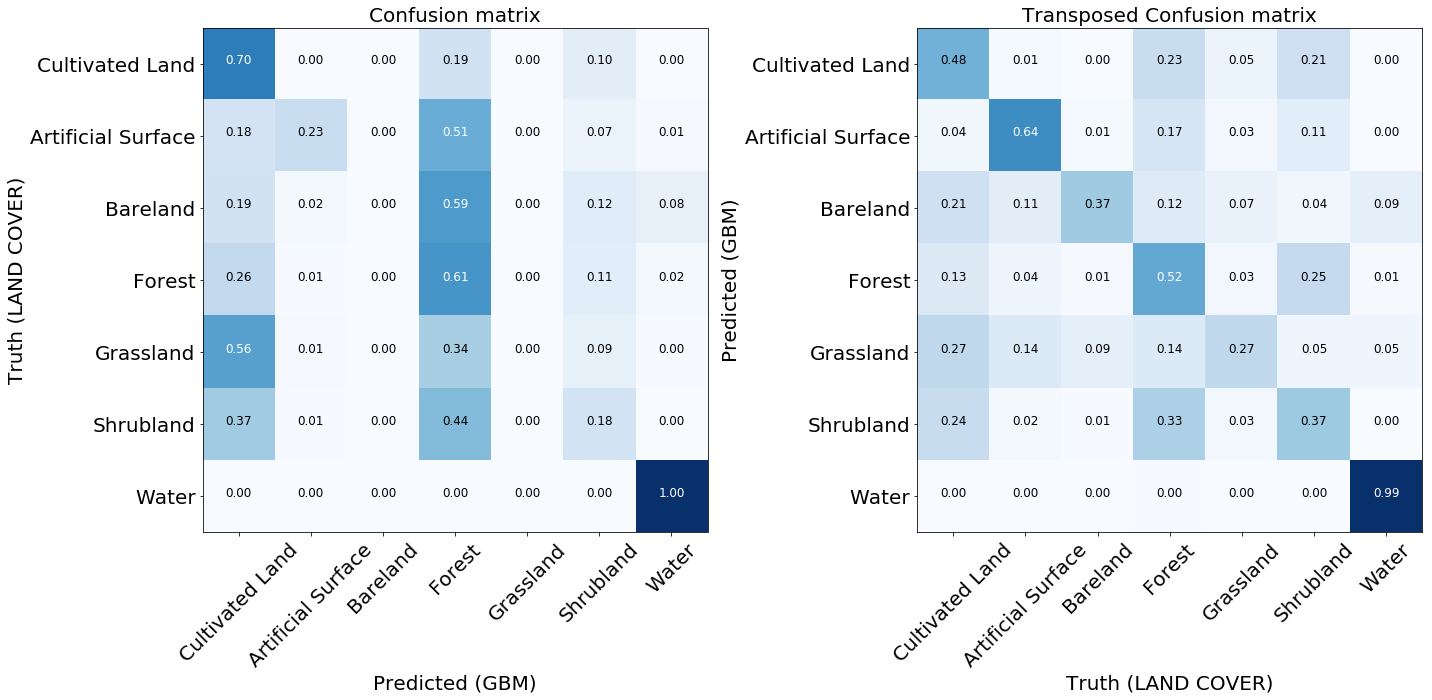

In [27]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(y_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth (LAND COVER)', 
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, y_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Truth (LAND COVER)', 
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

In [28]:
t, w, h, b = feature.shape
feature_mask = np.moveaxis(feature, 0, 2).reshape(w*h, t*b)
feature_mask = ma.array(feature_mask, mask=mask)
feature_mask.shape

(130951084, 6)

Classification of Unseen Data by LightGBM

In [29]:
%%time
predict = clf_sw.predict(feature_mask)
predict_proba = clf_sw.predict_proba(feature_mask)

Wall time: 1h 3min 58s


In [30]:
df = np.array(pd.DataFrame(predict))
df_proba = np.array(pd.DataFrame(predict_proba))
df_proba = np.moveaxis(df, 0, 1)

In [28]:
for i in range(len(df_proba)):
    tiff = df_proba[i].reshape(w,h)
    driver = ras.GetDriver()
    outputPath = os.getcwd()
    columns2Ras = 'Class0' + str(i) + 'prediction'
    #dfAsArr = np.array(predict).astype(int)
    #fAsArr = dfAsArr.reshape(nCols,nRows).T
    ns = driver.Create(os.path.join(outputPath,'%s_LandCover_2016.tif'%(columns2Ras)),\
                      col,row,1,GDT_Float32)
    ns.SetGeoTransform(gtr) 
    ns.SetProjection(prj)
    outputRas = ns.GetRasterBand(1)
    outputRas.WriteArray(tiff,0,0)
    ns.FlushCache()
    outputRas.FlushCache()
    del outputRas,ns

In [31]:
tiff = df.reshape(w,h)
training = ground_truth.reshape(w,h)

In [33]:
driver = ras.GetDriver()
outputPath = os.getcwd()
columns2Ras = 'prediction_SAR'
#dfAsArr = np.array(predict).astype(int)
#fAsArr = dfAsArr.reshape(nCols,nRows).T
ns = driver.Create(os.path.join(outputPath,'%s_LandCover_2017.tif'%(columns2Ras)),\
                      col,row,1,GDT_Float32)
ns.SetGeoTransform(gtr) 
ns.SetProjection(prj)
outputRas = ns.GetRasterBand(1)
outputRas.WriteArray(tiff,0,0)
ns.FlushCache()
outputRas.FlushCache()
del outputRas,ns,feature_mask,labels_test,labels_train

NameError: name 'feature_mask' is not defined

###### Parameter Tuning of Xgboost

In [20]:
X_train, yTrain = np.nan_to_num(X_train), np.nan_to_num(yTrain)

In [20]:
%%time
fit_params = {"eval_metric" : 'mlogloss', 
             "eval_set" : [(X_test, yTest)],
             'verbose': 0}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000], 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], 
              'max_depth': [1, 2, 3, 4, 5, 6, 7],
              'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
              'subsample': [0.8, 0.9, 1.0]}

model_xgb = xgb.XGBClassifier(random_state=42, objective='multi:softmax', 
                            num_class=len(labels_unique), 
                            metric='mlogloss', n_jobs=22)

grid_search = RandomizedSearchCV(
    estimator=model_xgb, param_distributions=param_test, 
    n_iter=2,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=42,
    verbose=True)

grid_search.fit(X_train, yTrain, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))
opt_parameters =  grid_search.best_params_

clf_sw = xgb.XGBClassifier(**model_xgb.get_params())
#Optimal parameter
clf_sw.set_params(**opt_parameters)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 278.6min finished


Best score reached: 0.8869909070248563 with params: {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7} 
Wall time: 5h 13min 39s
Compiler : 415 ms
Parser   : 297 ms


In [21]:
clf_sw = xgb.XGBClassifier(**model_xgb.get_params())
clf_sw.set_params(**opt_parameters)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7, gamma=0.3, learning_rate=0.03,
              max_delta_step=0, max_depth=1, metric='mlogloss',
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=22,
              nthread=None, num_class=7, objective='multi:softmax',
              random_state=42, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=0.9)

In [22]:
%%time
clf_sw.fit(features_train, labels_train)

Wall time: 42min 4s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7, gamma=0.3, learning_rate=0.03,
              max_delta_step=0, max_depth=1, metric='mlogloss',
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=22,
              nthread=None, num_class=7, objective='multi:softprob',
              random_state=42, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=0.9)

In [23]:
%%time
labels_test = clf_sw.predict(X_test)

Wall time: 5.16 s


In [24]:
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(y_test, labels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(y_test, labels_test, average='weighted')))

Classification accuracy 88.7%
Classification F1-score 88.0%


In [25]:
class_labels = []
class_label = np.unique(labels_test)
for i in class_label:
    class_labels.append(int(i))

class_names = [entry.class_name for entry in LULC]

f1_scores = metrics.f1_score(y_test, labels_test, labels=class_labels, average=None)
recall = metrics.recall_score(y_test, labels_test, labels=class_labels, average=None)
precision = metrics.precision_score(y_test, labels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * Cultivated Land      = 82.4 |  82.3  | 82.4
         * Artificial Surface   = 77.3 |  71.7  | 83.9
         * Bareland             = 33.3 |  21.7  | 71.4
         * Forest               = 74.9 |  89.5  | 64.3
         * Grassland            = 44.0 |  33.5  | 64.0
         * Shrubland            = 46.5 |  36.1  | 65.2
         * Water                = 99.7 |  99.4  | 99.9


In [26]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

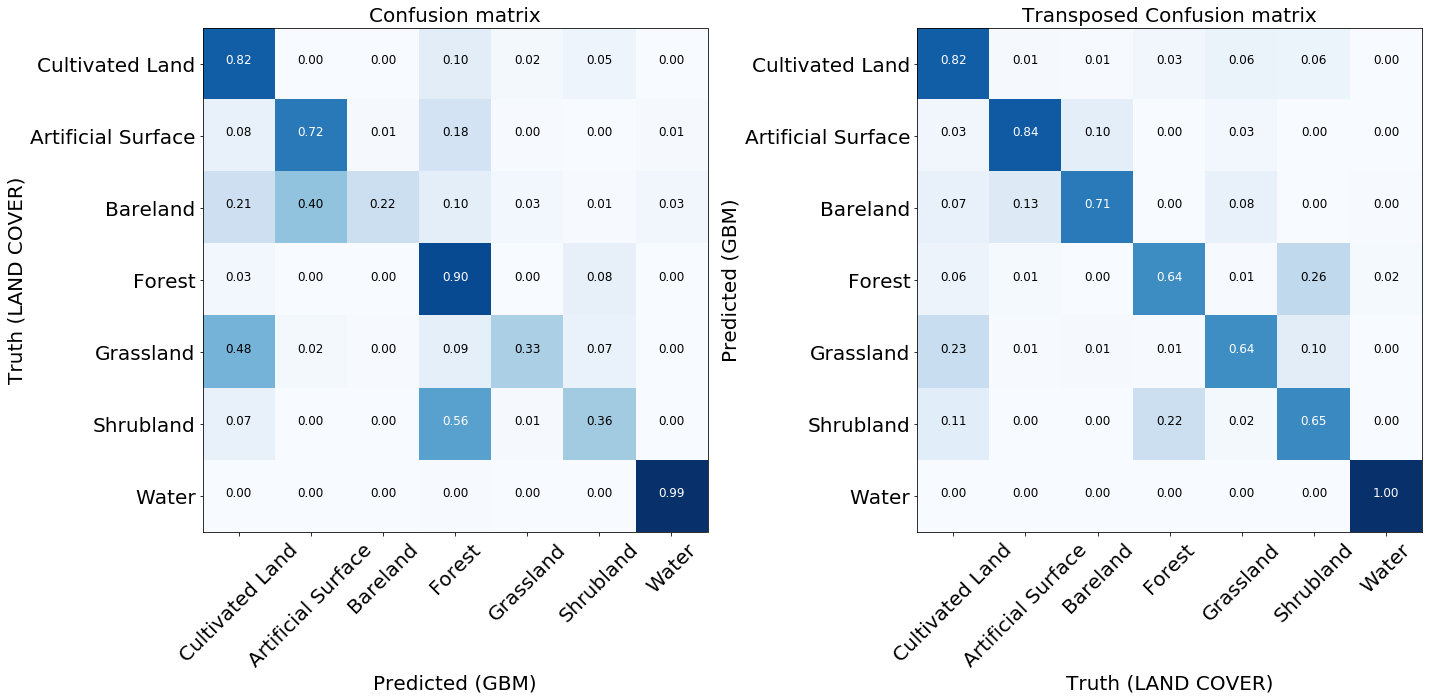

In [27]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(y_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth (LAND COVER)', 
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, y_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Truth (LAND COVER)', 
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

In [28]:
t, w, h, b = feature.shape
feature_mask = np.moveaxis(feature, 0, 2).reshape(w*h, t*b)
feature_mask = ma.array(feature_mask, mask=mask)
feature_mask.shape

(17724015, 91)

In [31]:
predict = clf_sw.predict(feature_mask)
df = np.array(pd.DataFrame(predict))

In [32]:
tiff = df.reshape(w,h)
training = ground_truth.reshape(w,h)

In [33]:
driver = ras.GetDriver()
outputPath = os.getcwd()
columns2Ras = 'prediction_XGB'
#dfAsArr = np.array(predict).astype(int)
#fAsArr = dfAsArr.reshape(nCols,nRows).T
ns = driver.Create(os.path.join(outputPath,'%s_LandCover_2018.tif'%(columns2Ras)),\
                      col,row,1,GDT_Float32)
ns.SetGeoTransform(gtr) 
ns.SetProjection(prj)
outputRas = ns.GetRasterBand(1)
outputRas.WriteArray(tiff,0,0)
ns.FlushCache()
outputRas.FlushCache()
del outputRas,ns,feature_mask,labels_test,labels_train